In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from torch.distributions import MultivariateNormal

In [3]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Generator and Noise

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Classifier

In [5]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar (CelebA is rgb, so 3 is your default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing classes.
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

# Model Training (Optional)

In [ ]:
z_dim = 64
batch_size = 128
device = 'cuda'

label_indices = range(40)
n_epochs = 3
display_step = 500
lr = 0.001
beta_1 = 0.5
beta_2 = 0.999
image_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = DataLoader(
    CelebA(".", split='train', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

classifier = Classifier(n_classes=len(label_indices)).to(device)
class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
cur_step = 0
classifier_losses = []
# classifier_val_losses = []

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):
        real = real.to(device)
        labels = labels[:, label_indices].to(device).float()

        class_opt.zero_grad()
        class_pred = classifier(real)
        class_loss = criterion(class_pred, labels)
        class_loss.backward() # Calculate the gradients
        class_opt.step() # Update the weights
        classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            class_mean = sum(classifier_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Classifier loss: {class_mean}")
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
            sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
            plt.legend()
            plt.show()
            torch.save({"classifier": classifier.state_dict()}, filename)
        cur_step += 1

# Loading the Pre-trained Model

In [8]:
z_dim = 64
batch_size = 128
device = 'cuda'
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/content/gdrive/MyDrive/Colab Notebooks/16 - GANs/models/pretrained_celeba.pth", 
                      map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("/content/gdrive/MyDrive/Colab Notebooks/16 - GANs/models/pretrained_classifier.pth", 
                        map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

# Feature Correlation
Now you can generate images using the generator. By also using the classifier, you will be generating images with different amounts of the "male" feature.

Before Updating


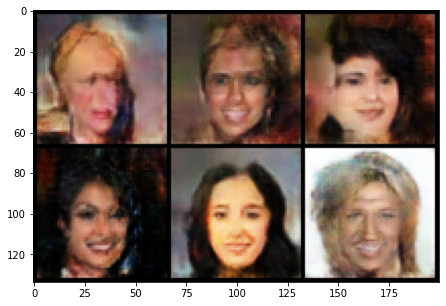

After Updating


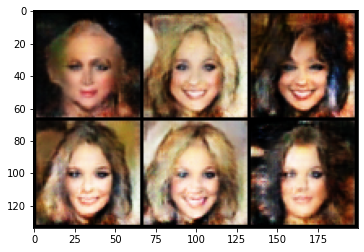

In [29]:
# generate a bunch of fake images with the generator
n_images = 6
fake_image_history = []
classification_history = []
grad_steps = 20 # How many gradient steps to take
skip = 2 # How many gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

n_features = len(feature_names)
# Set the target feature
target_feature = "Male"
target_indices = feature_names.index(target_feature)
noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

print('Before Updating')
fake = gen(new_noise) # (m, 3, 64, 64)
plt.figure(figsize=(15, 5))
show_tensor_images(fake)

# Additive direction (more of a feature), become more manly
# for i in range(grad_steps):
#     opt.zero_grad()
#     fake = gen(new_noise) # (m, 3, 64, 64)
#     fake_image_history += [fake]
#     classifications = classifier(fake) #(m, 40)
#     classification_history += [classifications.cpu().detach()]
#     fake_classes = classifications[:, target_indices].mean() # ()
#     fake_classes.backward()
#     new_noise.data += new_noise.grad / grad_steps

# Subtractive direction (less of a feature), become less manly
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps

classification_history = torch.stack(classification_history)

print('After Updating')
show_tensor_images(fake)

In [30]:
print(classification_history.shape)
print(starting_classifications[None, :, :].shape)

torch.Size([20, 6, 40])
torch.Size([1, 6, 40])


You've now generated image samples, which have increasing or decreasing amounts of the target feature. You can visualize the way in which that affects other classified features. The x-axis will show you the amount of change in your target feature and the y-axis shows how much the other features change, as detected in those images by the classifier. Together, you will be able to see the covariance of "male-ness" and other features.

You are started off with a set of features that have interesting associations with "male-ness", but you are welcome to change the features in `other_features` with others from `feature_names`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

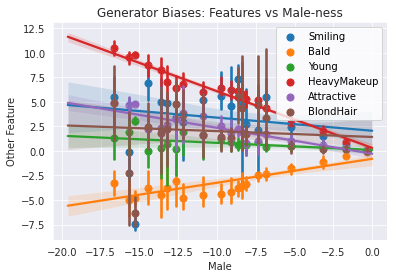

In [31]:
# Set the other features
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive", 'BlondHair']
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()
for other_feature in other_features:
    other_indices = feature_names.index(other_feature)
    with sns.axes_style("darkgrid"):
        sns.regplot(
            classification_changes[:, :, target_indices].reshape(-1), 
            classification_changes[:, :, other_indices].reshape(-1), 
            fit_reg=True,
            truncate=True,
            ci=99,
            x_ci=99,
            x_bins=len(classification_history),
            label=other_feature
        )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

This correlation detection can be used to reduce bias by penalizing this type of correlation in the loss during the training of the generator. However, currently there is no rigorous and accepted solution for debiasing GANs. A first step that you can take in the right direction comes before training the model: make sure that your dataset is inclusive and representative, and consider how you can mitigate the biases resulting from whatever data collection method you used—for example, getting a representative labelers for your task. 

It is important to note that, as highlighted in the lecture and by many researchers including [Timnit Gebru and Emily Denton](https://sites.google.com/view/fatecv-tutorial/schedule), a diverse dataset alone is not enough to eliminate bias. Even diverse datasets can reinforce existing structural biases by simply capturing common social biases. Mitigating these biases is an important and active area of research.

#### Note on CelebA
You may have noticed that there are obvious correlations between the feature you are using, "male", and other seemingly unrelates features, "smiling" and "young" for example. This is because the CelebA dataset labels had no serious consideration for diversity. The data represents the biases their labelers, the dataset creators, the social biases as a result of using a dataset based on American celebrities, and many others. Equipped with knowledge about bias, we trust that you will do better in the future datasets you create.

# Quantification
Finally, you can also quantitatively evaluate the degree to which these factors covary.

In [ ]:
def get_top_covariances(classification_changes, target_index, top_n=10):
    '''
    Function for getting the top n covariances: Given a list of classification changes
    and the index of the target feature, returns (1) a list or tensor (numpy or torch) of the indices
    corresponding to the n most covarying factors in terms of absolute covariance
    and (2) a list or tensor (numpy or torch) of the degrees to which they covary.
    Parameters:
        classification_changes: relative changes in classifications of each generated image 
          resulting from optimizing the target feature (see above for a visualization)
        target_index: the index of the target feature, a scalar
        top_n: the top most number of elements to return, default is 10
    '''
    flattened_changes = classification_changes.reshape(-1, classification_changes.shape[-1]).T
    covariances = np.cov(flattened_changes)
    relevant_indices = torch.topk(torch.Tensor(np.abs(covariances[target_index])), top_n + 1)[1][1:].numpy()
    highest_covariances = covariances[target_index, relevant_indices]
    return relevant_indices, highest_covariances

In [ ]:
# UNIT TEST
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, 5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [5, 4, 2, 11]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1])

relevant_indices, highest_covariances = get_top_covariances(foo, 0, top_n=3)

In [ ]:
relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print(relevant_indices)
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")

[36  9 18 38  8  0 31 24 22 29]
WearingLipstick  -15.854427
BlondHair  -15.739892
HeavyMakeup  -14.203229
WearingNecktie  12.153121
BlackHair  11.736132
5oClockShadow  11.109759
Smiling  -11.017221
NoBeard  -10.002584
Mustache  9.440355
RosyCheeks  -7.783785


One of the major sources of difficulty with identifying bias and fairness, as discussed in the lectures, is that there are many ways you might reasonably define these terms. Here are three ways that are computationally useful and [widely referenced](http://m-mitchell.com/papers/Adversarial_Bias_Mitigation.pdf). They are, by no means, the only definitions of fairness (see more details [here](https://developers.google.com/machine-learning/glossary/fairness)):


1.   Demographic parity: the overall distribution of the predictions made by a predictor is the same for different values of a protected class. 
2.   Equality of odds: all else being equal, the probability that you predict correctly or incorrectly is the same for different values of a protected class. 
2.   Equality of opportunity: all else being equal, the probability that you predict correctly is the same for different valus of a protected class (weaker than equality of odds).

With GANs also being used to help downstream classifiers (you will see this firsthand in future assignments), these definitions of fairness will impact, as well as depend on, your downstream task. It is important to work towards creating a fair GAN according to the definition you choose. Pursuing any of them is virtually always better than blindly labelling data, creating a GAN, and sampling its generations.